In [17]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [18]:
def pos_distance(target_pos, final_positions):
    return np.linalg.norm(final_positions - target_pos, axis=1).astype(np.float32)


def quat_angle_error(q1, q2):
    q1 = q1 / np.linalg.norm(q1)
    q2 = q2 / np.linalg.norm(q2)
    dot = np.clip(np.abs(np.dot(q1, q2)), -1.0, 1.0)
    return 2 * np.arccos(dot)

In [19]:
data = []
with h5py.File("../dataset.h5", "r") as f:
    primitives = f.attrs["primitives"]

    for scene_id in f.keys():
        dp = f[scene_id]
        num_objects = len(dp["poses"])
        for oi in range(num_objects):
            object_pose = dp["poses"][oi]
            object_size = dp["sizes"][oi]
            target_pose = dp["target_poses"][oi]
            for pi, primitive in enumerate(primitives):
                primitive_parts = primitive.split("_")
                data.append(
                    {
                        "scene_id": scene_id,
                        "object_id": oi,
                        "object_size": object_size,
                        "target_pose": target_pose,
                        "primitive": primitive,
                        "primitive_type": primitive_parts[0],
                        "feasible": bool(dp["feasibles"][oi][pi]),
                        "final_pose": dp["final_poses"][oi][pi],
                    }
                )

In [20]:
df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")

# Calculate errors
df["object_volume"] = df["object_size"].apply(np.prod)
df["distance"] = df.apply(lambda row: np.linalg.norm(row["target_pose"][:3] - row["final_pose"][:3]), axis=1)
df["pos_error"] = df.apply(lambda row: np.linalg.norm(row["target_pose"][:3] - row["final_pose"][:3]), axis=1)
df["ori_error"] = df.apply(lambda row: quat_angle_error(row["target_pose"][4:], row["final_pose"][4:]), axis=1)

# Filter only feasible attempts (what we're trying to predict)
df_feas = df[df["feasible"]].copy()
print(f"Feasible samples: {len(df_feas)} ({len(df_feas) / len(df):.1%})")

Total samples: 397552
Feasible samples: 120486 (30.3%)


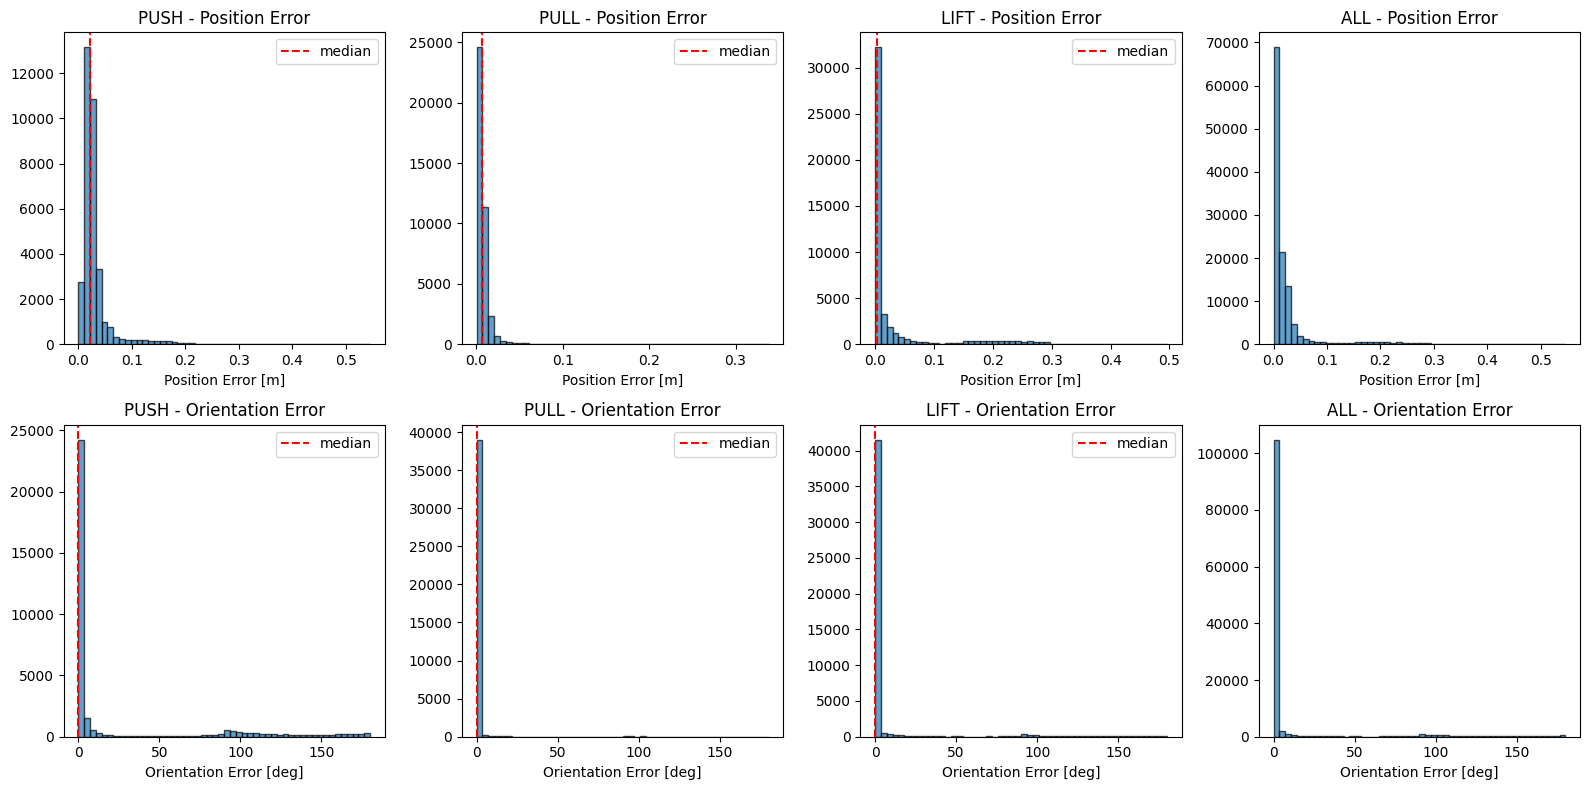


=== Error Statistics by Primitive Type ===

PUSH:
  Pos Error: mean=0.0313, median=0.0228, std=0.0327
  Ori Error: mean=25.4°, median=0.0°, std=50.3°

PULL:
  Pos Error: mean=0.0088, median=0.0059, std=0.0151
  Ori Error: mean=1.9°, median=0.0°, std=14.3°

LIFT:
  Pos Error: mean=0.0320, median=0.0027, std=0.0686
  Ori Error: mean=8.4°, median=0.0°, std=30.6°


In [21]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ptype in enumerate(["push", "pull", "lift"]):
    data = df_feas[df_feas["primitive_type"] == ptype]

    # Position error
    axes[0, i].hist(data["pos_error"], bins=50, alpha=0.7, edgecolor="black")
    axes[0, i].set_title(f"{ptype.upper()} - Position Error")
    axes[0, i].set_xlabel("Position Error [m]")
    axes[0, i].axvline(data["pos_error"].median(), color="r", linestyle="--", label="median")
    axes[0, i].legend()

    # Orientation error
    axes[1, i].hist(np.rad2deg(data["ori_error"]), bins=50, alpha=0.7, edgecolor="black")
    axes[1, i].set_title(f"{ptype.upper()} - Orientation Error")
    axes[1, i].set_xlabel("Orientation Error [deg]")
    axes[1, i].axvline(np.rad2deg(data["ori_error"].median()), color="r", linestyle="--", label="median")
    axes[1, i].legend()

# Combined
axes[0, 3].hist(df_feas["pos_error"], bins=50, alpha=0.7, edgecolor="black")
axes[0, 3].set_title("ALL - Position Error")
axes[0, 3].set_xlabel("Position Error [m]")

axes[1, 3].hist(np.rad2deg(df_feas["ori_error"]), bins=50, alpha=0.7, edgecolor="black")
axes[1, 3].set_title("ALL - Orientation Error")
axes[1, 3].set_xlabel("Orientation Error [deg]")

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Error Statistics by Primitive Type ===")
for ptype in ["push", "pull", "lift"]:
    data = df_feas[df_feas["primitive_type"] == ptype]
    print(f"\n{ptype.upper()}:")
    print(f"  Pos Error: mean={data['pos_error'].mean():.4f}, median={data['pos_error'].median():.4f}, std={data['pos_error'].std():.4f}")
    print(
        f"  Ori Error: mean={np.rad2deg(data['ori_error'].mean()):.1f}°, "
        f"median={np.rad2deg(data['ori_error'].median()):.1f}°, "
        f"std={np.rad2deg(data['ori_error'].std()):.1f}°"
    )

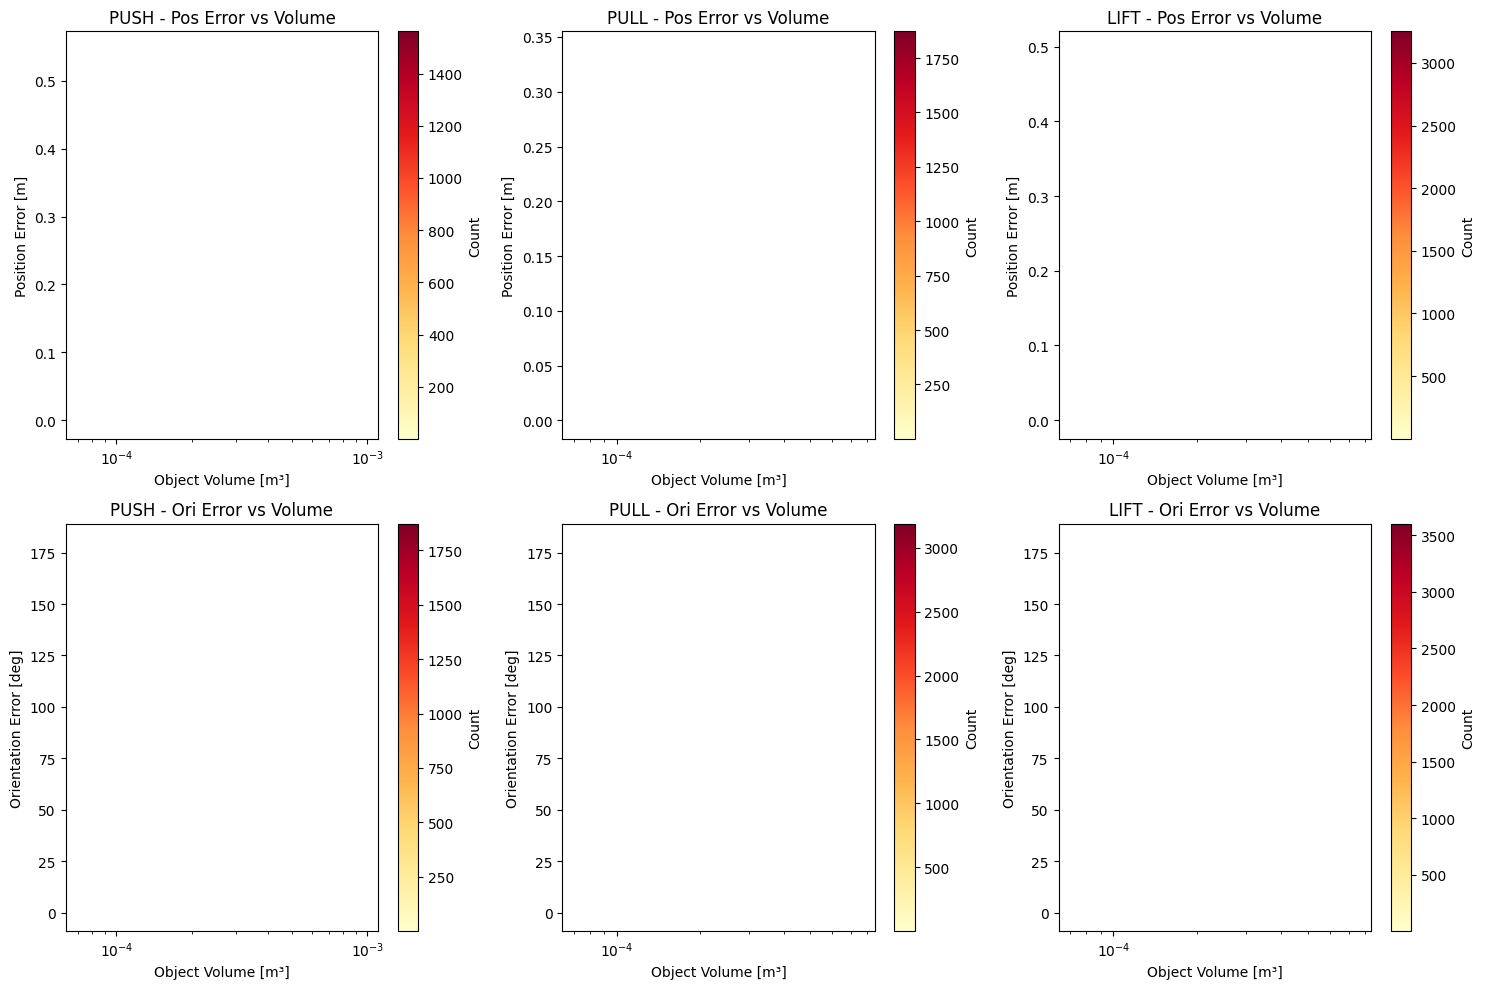

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ptype in enumerate(["push", "pull", "lift"]):
    data = df_feas[df_feas["primitive_type"] == ptype]

    # Position error vs volume
    hb1 = axes[0, i].hexbin(data["object_volume"], data["pos_error"], gridsize=30, cmap="YlOrRd", mincnt=1)
    axes[0, i].set_xlabel("Object Volume [m³]")
    axes[0, i].set_ylabel("Position Error [m]")
    axes[0, i].set_title(f"{ptype.upper()} - Pos Error vs Volume")
    axes[0, i].set_xscale("log")
    plt.colorbar(hb1, ax=axes[0, i], label="Count")

    # Orientation error vs volume
    hb2 = axes[1, i].hexbin(data["object_volume"], np.rad2deg(data["ori_error"]), gridsize=30, cmap="YlOrRd", mincnt=1)
    axes[1, i].set_xlabel("Object Volume [m³]")
    axes[1, i].set_ylabel("Orientation Error [deg]")
    axes[1, i].set_title(f"{ptype.upper()} - Ori Error vs Volume")
    axes[1, i].set_xscale("log")
    plt.colorbar(hb2, ax=axes[1, i], label="Count")

plt.tight_layout()
plt.show()

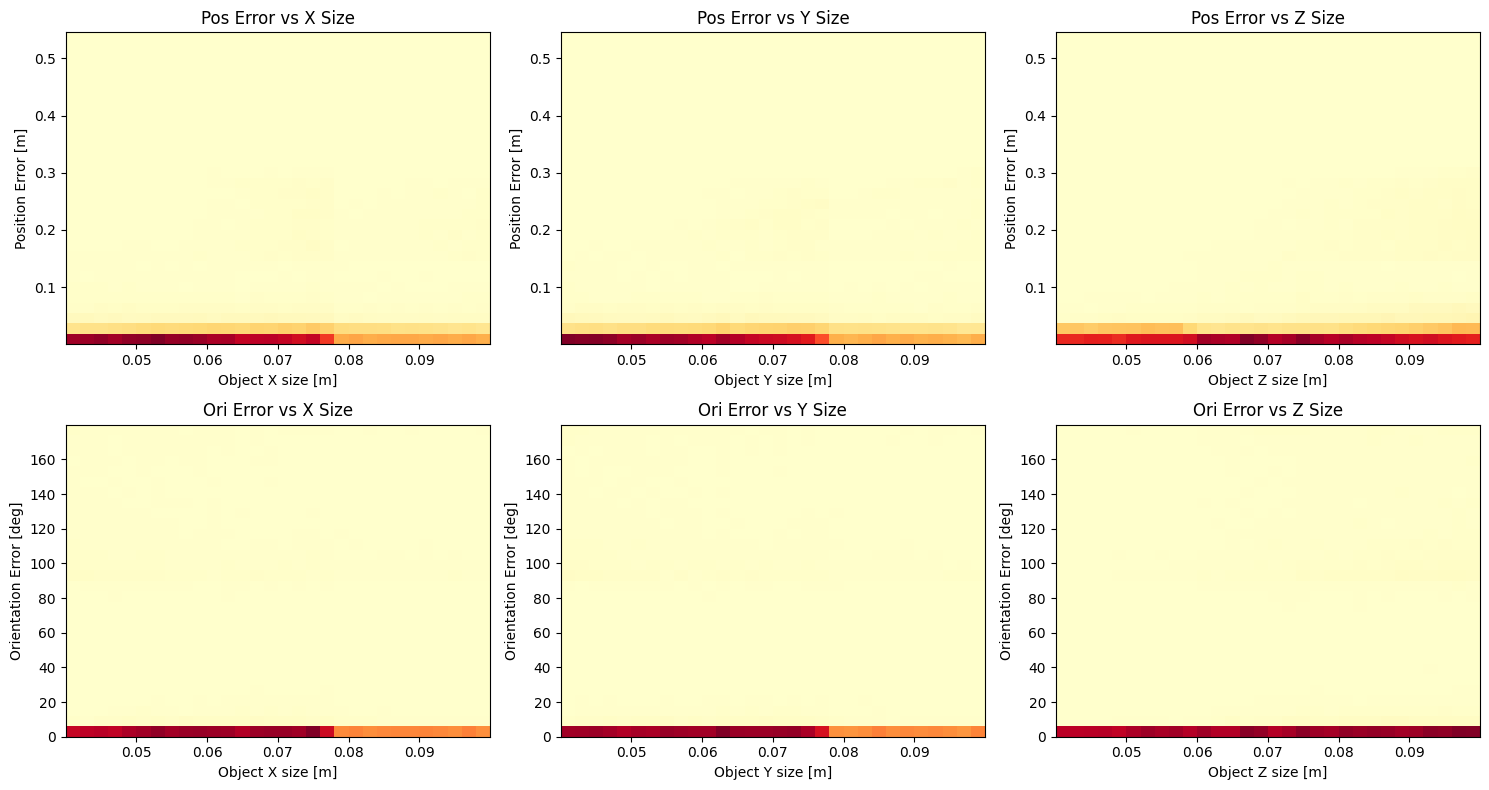

In [23]:
for i, axis in enumerate(["x", "y", "z"]):
    df_feas[f"size_{axis}"] = df_feas["object_size"].apply(lambda s: s[i])

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, axis in enumerate(["x", "y", "z"]):
    # Position error - combined all primitives
    axes[0, i].hist2d(df_feas[f"size_{axis}"], df_feas["pos_error"], bins=30, cmap="YlOrRd")
    axes[0, i].set_xlabel(f"Object {axis.upper()} size [m]")
    axes[0, i].set_ylabel("Position Error [m]")
    axes[0, i].set_title(f"Pos Error vs {axis.upper()} Size")

    # Orientation error
    axes[1, i].hist2d(df_feas[f"size_{axis}"], np.rad2deg(df_feas["ori_error"]), bins=30, cmap="YlOrRd")
    axes[1, i].set_xlabel(f"Object {axis.upper()} size [m]")
    axes[1, i].set_ylabel("Orientation Error [deg]")
    axes[1, i].set_title(f"Ori Error vs {axis.upper()} Size")

plt.tight_layout()
plt.show()

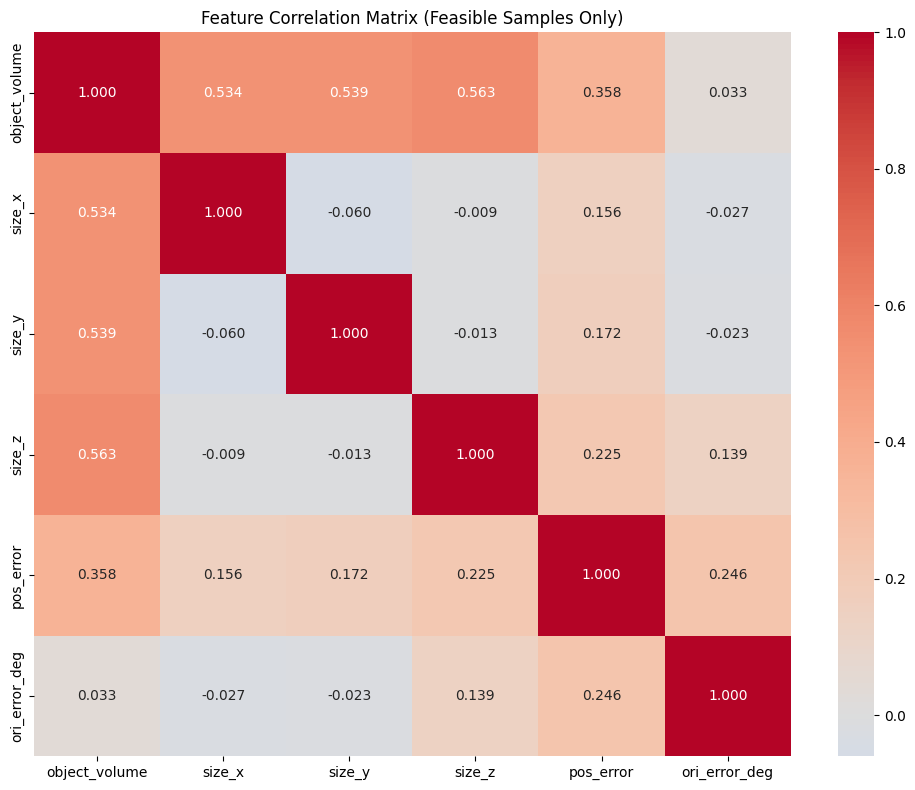


=== Correlations with Position Error ===
pos_error        1.000000
object_volume    0.358381
ori_error_deg    0.246426
size_z           0.225163
size_y           0.171770
size_x           0.155543
Name: pos_error, dtype: float64

=== Correlations with Orientation Error ===
ori_error_deg    1.000000
pos_error        0.246426
size_z           0.138579
object_volume    0.032524
size_y          -0.022732
size_x          -0.026791
Name: ori_error_deg, dtype: float64


In [24]:
feature_cols = ["object_volume", "size_x", "size_y", "size_z", "pos_error", "ori_error"]
corr_data = df_feas[feature_cols].copy()
corr_data["ori_error_deg"] = np.rad2deg(corr_data["ori_error"])
corr_data = corr_data.drop("ori_error", axis=1)

correlation_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".3f")
plt.title("Feature Correlation Matrix (Feasible Samples Only)")
plt.tight_layout()
plt.show()

print("\n=== Correlations with Position Error ===")
print(correlation_matrix["pos_error"].sort_values(ascending=False))

print("\n=== Correlations with Orientation Error ===")
print(correlation_matrix["ori_error_deg"].sort_values(ascending=False))

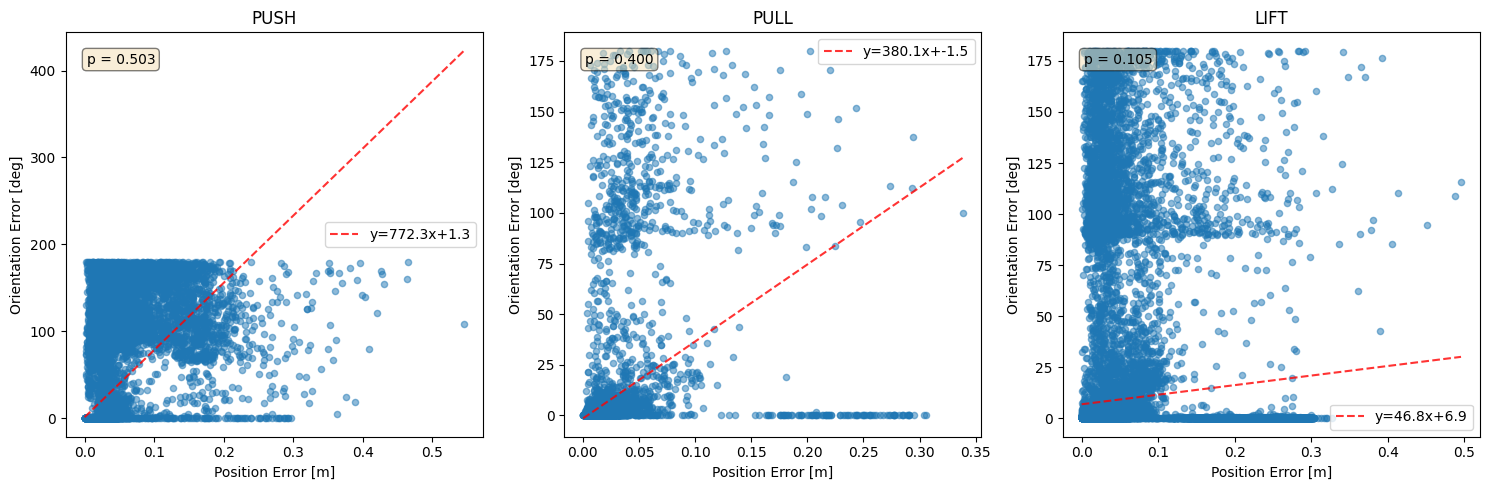

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ptype in enumerate(["push", "pull", "lift"]):
    data = df_feas[df_feas["primitive_type"] == ptype]

    axes[i].scatter(data["pos_error"], np.rad2deg(data["ori_error"]), alpha=0.5, s=20)
    axes[i].set_xlabel("Position Error [m]")
    axes[i].set_ylabel("Orientation Error [deg]")
    axes[i].set_title(f"{ptype.upper()}")

    # Fit line
    z = np.polyfit(data["pos_error"], np.rad2deg(data["ori_error"]), 1)
    p = np.poly1d(z)
    x_line = np.linspace(data["pos_error"].min(), data["pos_error"].max(), 100)
    axes[i].plot(x_line, p(x_line), "r--", alpha=0.8, label=f"y={z[0]:.1f}x+{z[1]:.1f}")

    # Correlation
    corr = data[["pos_error", "ori_error"]].corr().iloc[0, 1]
    axes[i].text(
        0.05, 0.95, f"p = {corr:.3f}", transform=axes[i].transAxes, verticalalignment="top", bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )
    axes[i].legend()

plt.tight_layout()
plt.show()


PUSH GMM Cluster Centers:
  Cluster 0: pos=0.0193m, ori=0.0°
  Cluster 1: pos=0.0491m, ori=63.4°

PULL GMM Cluster Centers:
  Cluster 0: pos=0.0068m, ori=0.0°
  Cluster 1: pos=0.0401m, ori=30.4°

LIFT GMM Cluster Centers:
  Cluster 0: pos=0.0292m, ori=0.0°
  Cluster 1: pos=0.0499m, ori=63.1°


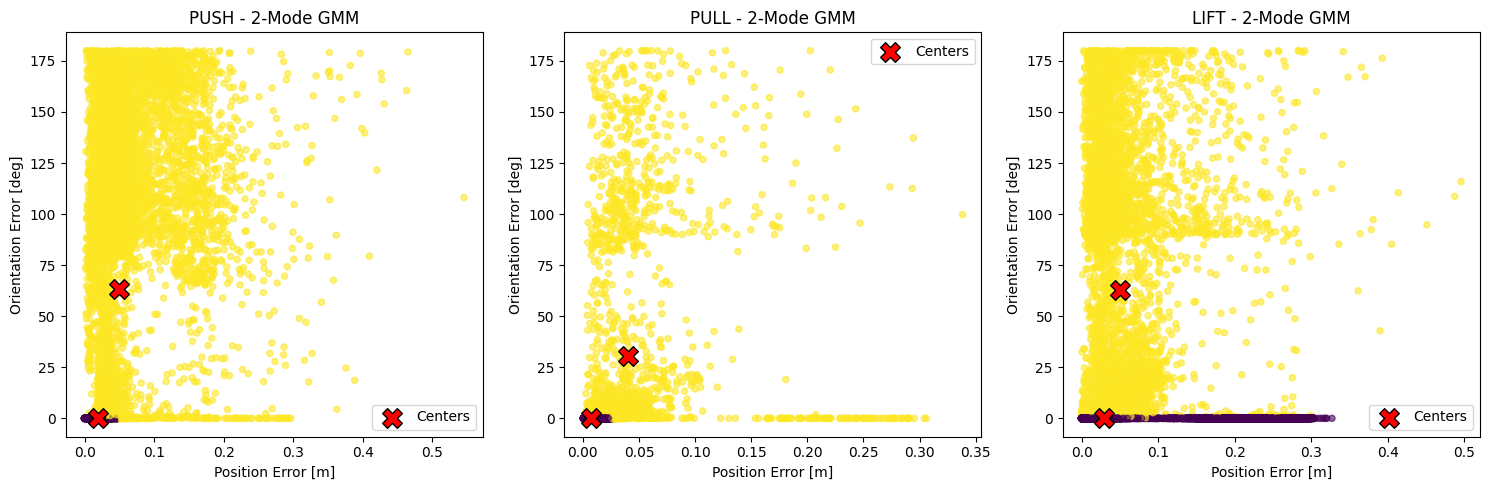

In [26]:
from sklearn.mixture import GaussianMixture

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ptype in enumerate(["push", "pull", "lift"]):
    data = df_feas[df_feas["primitive_type"] == ptype]

    X = data[["pos_error", "ori_error"]].values

    # Fit GMM with 2 components
    gmm = GaussianMixture(n_components=2, random_state=42)
    labels = gmm.fit_predict(X)

    scatter = axes[i].scatter(data["pos_error"], np.rad2deg(data["ori_error"]), c=labels, cmap="viridis", alpha=0.6, s=20)
    axes[i].set_xlabel("Position Error [m]")
    axes[i].set_ylabel("Orientation Error [deg]")
    axes[i].set_title(f"{ptype.upper()} - 2-Mode GMM")

    # Plot cluster centers
    centers = gmm.means_
    axes[i].scatter(centers[:, 0], np.rad2deg(centers[:, 1]), c="red", marker="X", s=200, edgecolors="black", label="Centers")
    axes[i].legend()

    print(f"\n{ptype.upper()} GMM Cluster Centers:")
    for j, center in enumerate(centers):
        print(f"  Cluster {j}: pos={center[0]:.4f}m, ori={np.rad2deg(center[1]):.1f}°")

plt.tight_layout()
plt.show()

/tmp/ipykernel_5956/2384715113.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df_feas[df_feas["primitive"] == p]["pos_error"] for p in primitives], labels=primitives)
/tmp/ipykernel_5956/2384715113.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(


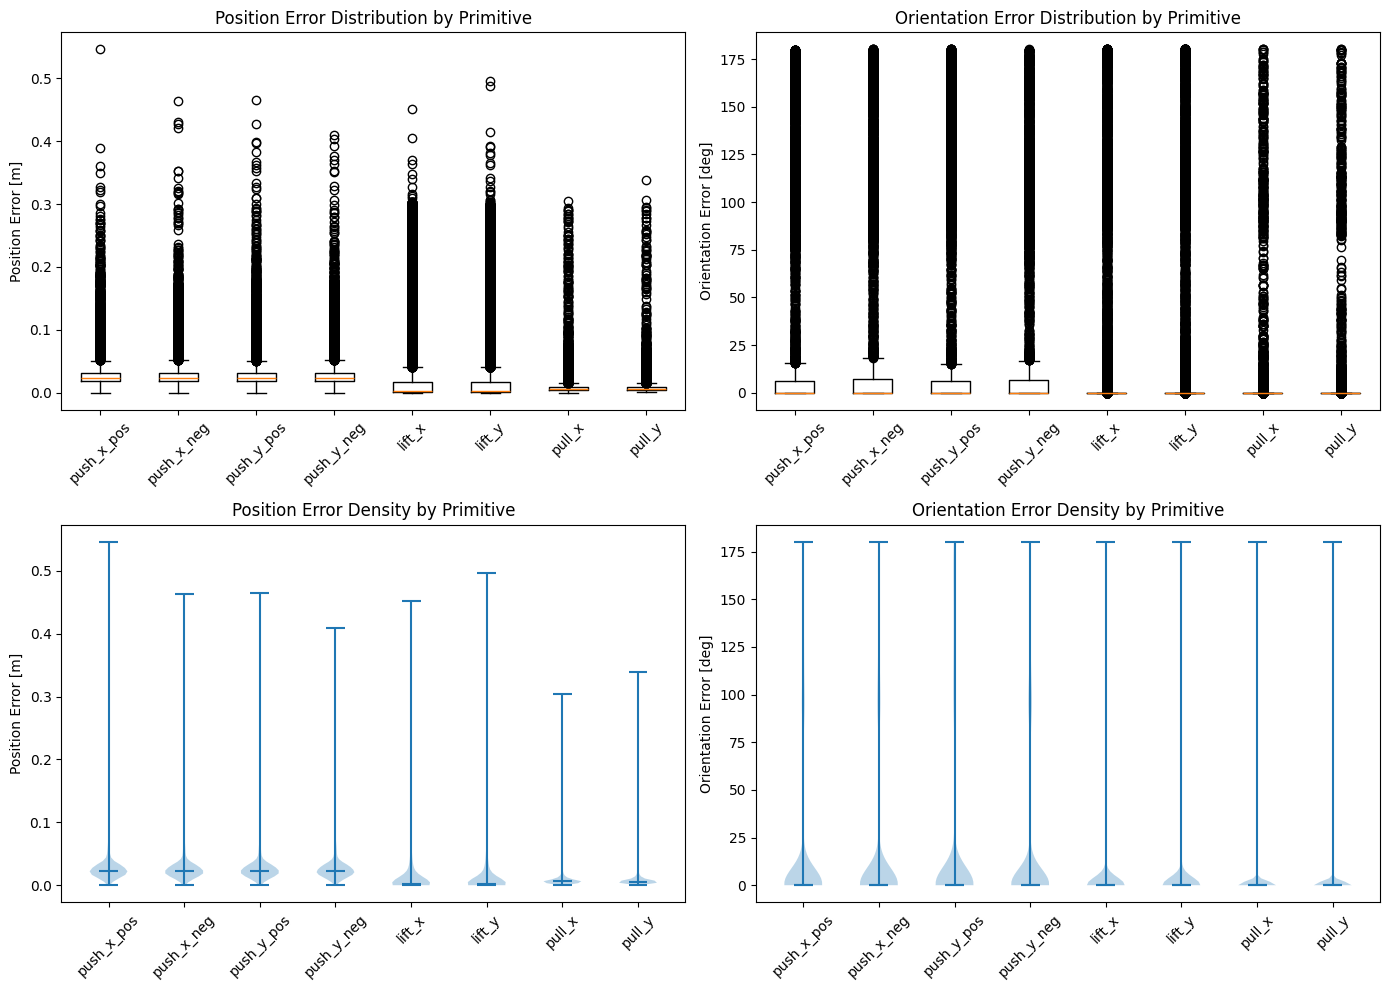


=== Per-Primitive Error Statistics ===

push_x_pos:
  Pos: μ=0.0310, σ=0.0319, med=0.0230
  Ori: μ=24.7°, σ=49.3°, med=0.0°

push_x_neg:
  Pos: μ=0.0313, σ=0.0324, med=0.0227
  Ori: μ=26.4°, σ=51.4°, med=0.0°

push_y_pos:
  Pos: μ=0.0317, σ=0.0343, med=0.0227
  Ori: μ=26.9°, σ=53.2°, med=0.0°

push_y_neg:
  Pos: μ=0.0310, σ=0.0321, med=0.0228
  Ori: μ=23.8°, σ=46.7°, med=0.0°

lift_x:
  Pos: μ=0.0328, σ=0.0702, med=0.0027
  Ori: μ=8.4°, σ=30.7°, med=0.0°

lift_y:
  Pos: μ=0.0312, σ=0.0669, med=0.0027
  Ori: μ=8.3°, σ=30.4°, med=0.0°

pull_x:
  Pos: μ=0.0091, σ=0.0160, med=0.0060
  Ori: μ=1.9°, σ=14.6°, med=0.0°

pull_y:
  Pos: μ=0.0086, σ=0.0141, med=0.0059
  Ori: μ=1.8°, σ=14.1°, med=0.0°


In [27]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Box plots
axes[0, 0].boxplot([df_feas[df_feas["primitive"] == p]["pos_error"] for p in primitives], labels=primitives)
axes[0, 0].set_title("Position Error Distribution by Primitive")
axes[0, 0].set_ylabel("Position Error [m]")
axes[0, 0].tick_params(axis="x", rotation=45)

axes[0, 1].boxplot(
    [np.rad2deg(df_feas[df_feas["primitive"] == p]["ori_error"]) for p in primitives],
    labels=primitives,
)
axes[0, 1].set_title("Orientation Error Distribution by Primitive")
axes[0, 1].set_ylabel("Orientation Error [deg]")
axes[0, 1].tick_params(axis="x", rotation=45)

# Violin plots
parts = axes[1, 0].violinplot([df_feas[df_feas["primitive"] == p]["pos_error"].values for p in primitives], showmedians=True)
axes[1, 0].set_xticks(range(1, len(primitives) + 1))
axes[1, 0].set_xticklabels(primitives, rotation=45)
axes[1, 0].set_title("Position Error Density by Primitive")
axes[1, 0].set_ylabel("Position Error [m]")

parts = axes[1, 1].violinplot([np.rad2deg(df_feas[df_feas["primitive"] == p]["ori_error"].values) for p in primitives], showmedians=True)
axes[1, 1].set_xticks(range(1, len(primitives) + 1))
axes[1, 1].set_xticklabels(primitives, rotation=45)
axes[1, 1].set_title("Orientation Error Density by Primitive")
axes[1, 1].set_ylabel("Orientation Error [deg]")

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Per-Primitive Error Statistics ===")
for prim in primitives:
    data = df_feas[df_feas["primitive"] == prim]
    print(f"\n{prim}:")
    print(f"  Pos: μ={data['pos_error'].mean():.4f}, σ={data['pos_error'].std():.4f}, med={data['pos_error'].median():.4f}")
    print(
        f"  Ori: μ={np.rad2deg(data['ori_error'].mean()):.1f}°, "
        f"σ={np.rad2deg(data['ori_error'].std()):.1f}°, "
        f"med={np.rad2deg(data['ori_error'].median()):.1f}°"
    )